In [19]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.models import Sequential

%matplotlib inline

In [76]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')
target_col = 'close'

In [38]:
data

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2016-11-04,706.64,681.27,684.87,48235.17,3.376272e+07,702.08,direct,
2016-11-05,706.38,694.03,702.08,22018.95,1.555457e+07,702.11,direct,
2016-11-06,714.13,697.63,702.11,25809.88,1.836357e+07,709.91,direct,
2016-11-07,711.66,698.35,709.91,30743.71,2.179737e+07,705.40,direct,
2016-11-08,714.63,700.96,705.40,39732.33,2.826224e+07,710.90,direct,
...,...,...,...,...,...,...,...,...
2022-04-23,39988.54,39305.67,39716.04,11481.51,4.556596e+08,39445.97,direct,
2022-04-24,39943.44,39044.29,39445.97,12668.56,5.012721e+08,39466.26,direct,
2022-04-25,40590.80,38234.70,39466.26,38636.23,1.514244e+09,40437.52,direct,


<AxesSubplot:xlabel='time', ylabel='close'>

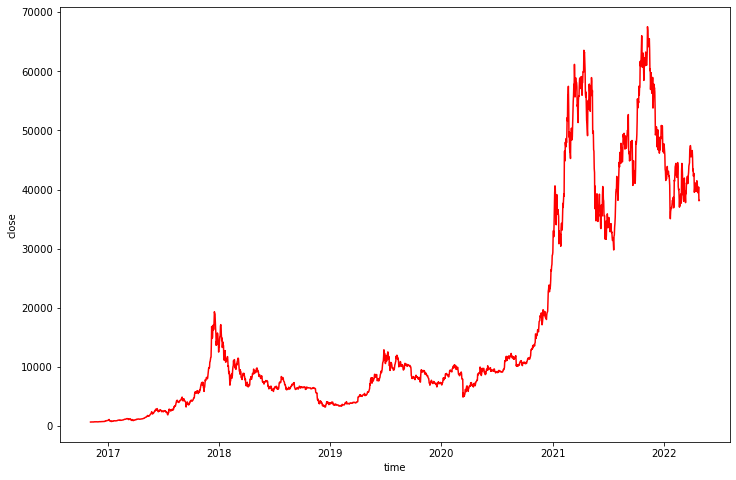

In [72]:
plt.figure(figsize=(12,8))
sns.lineplot(x='time', y='close', data=data, color='red')

<AxesSubplot:>

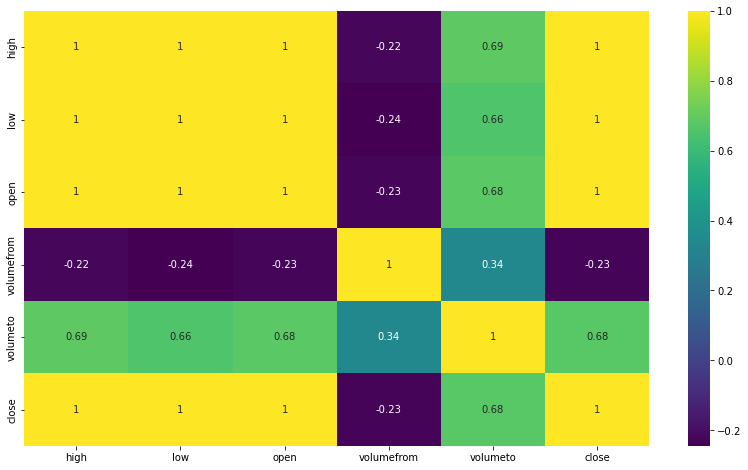

In [59]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(), cmap='viridis', annot=True)

In [77]:
data = data.drop(['conversionType', 'conversionSymbol'], axis=1)

In [78]:
data

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-11-04,706.64,681.27,684.87,48235.17,3.376272e+07,702.08
2016-11-05,706.38,694.03,702.08,22018.95,1.555457e+07,702.11
2016-11-06,714.13,697.63,702.11,25809.88,1.836357e+07,709.91
2016-11-07,711.66,698.35,709.91,30743.71,2.179737e+07,705.40
2016-11-08,714.63,700.96,705.40,39732.33,2.826224e+07,710.90
...,...,...,...,...,...,...
2022-04-23,39988.54,39305.67,39716.04,11481.51,4.556596e+08,39445.97
2022-04-24,39943.44,39044.29,39445.97,12668.56,5.012721e+08,39466.26
2022-04-25,40590.80,38234.70,39466.26,38636.23,1.514244e+09,40437.52


In [81]:
X = data.drop('close', axis=1)
y = data['close']

In [80]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [85]:
#X_train.shape (1400, 5)

In [87]:
from sklearn.preprocessing import MinMaxScaler

In [88]:
scaler = MinMaxScaler()

In [90]:
norm_X_train = scaler.fit_transform(X_train)

In [96]:
norm_X_train

array([[0.10310971, 0.10340395, 0.10238174, 0.09405502, 0.0317012 ],
       [0.1200891 , 0.11823623, 0.11946605, 0.16896702, 0.06485373],
       [0.09190391, 0.09040707, 0.09264395, 0.09864653, 0.02938868],
       ...,
       [0.04743643, 0.04790043, 0.04776198, 0.06803182, 0.01113568],
       [0.19352796, 0.1910736 , 0.19557306, 0.06583142, 0.03986334],
       [0.10009564, 0.09895576, 0.09755449, 0.05894097, 0.0189614 ]])

In [ ]:
model = Sequential()

model.add(LSTM(shape=()))